<a href="https://colab.research.google.com/github/raymond92928/AIcouse/blob/main/%E6%89%8B%E5%AF%AB%E9%98%BF%E6%8B%89%E4%BC%AF%E6%95%B8%E5%AD%97%E8%BE%A8%E8%AD%98_%E5%AE%8C%E6%95%B4%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 手寫阿拉伯數字辨識 完整版

## 載入套件

In [ ]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

## 設定參數

In [ ]:
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cpu'

## 步驟1：載入 MNIST 手寫阿拉伯數字資料

In [ ]:
# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True,
                 transform=transforms.ToTensor())

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True,
                 transform=transforms.ToTensor())

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 87852219.02it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30110786.43it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21434787.75it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16254717.38it/s]


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## 步驟2：資料探索

In [ ]:
train_ds.data.shape, train_ds.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [ ]:
# 訓練資料前10筆圖片的數字
train_ds.targets[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [ ]:
# 顯示第1張圖片內含值
train_ds.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
# 將非0的數字轉為1，顯示第1張圖片
data = train_ds.data[0].clone()
data[data>0]=1
data = data.numpy()

# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000001111111111110000',
 '0000000011111111111111110000',
 '0000000111111111111111100000',
 '0000000111111111110000000000',
 '0000000011111110110000000000',
 '0000000001111100000000000000',
 '0000000000011110000000000000',
 '0000000000011110000000000000',
 '0000000000001111110000000000',
 '0000000000000111111000000000',
 '0000000000000011111100000000',
 '0000000000000001111100000000',
 '0000000000000000011110000000',
 '0000000000000011111110000000',
 '0000000000001111111100000000',
 '0000000000111111111000000000',
 '0000000011111111110000000000',
 '0000001111111111000000000000',
 '0000111111111100000000000000',
 '0000111111110000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

In [ ]:
# 將非0的數字轉為1，顯示第2張圖片
data = train_ds.data[1].clone()
data[data>0]=1
data = data.numpy()

# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000001111100000000',
 '0000000000000011111100000000',
 '0000000000000111111111000000',
 '0000000000011111111111000000',
 '0000000000011111111111000000',
 '0000000000111111111111000000',
 '0000000001111111110011100000',
 '0000000011111100000011100000',
 '0000000111111100000011100000',
 '0000000111100000000011100000',
 '0000000111000000000011100000',
 '0000001111000000000011100000',
 '0000001111000000001111100000',
 '0000001110000000011111000000',
 '0000001110000000111100000000',
 '0000001110000001111000000000',
 '0000001111111111111000000000',
 '0000001111111111100000000000',
 '0000001111111110000000000000',
 '0000000111111100000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

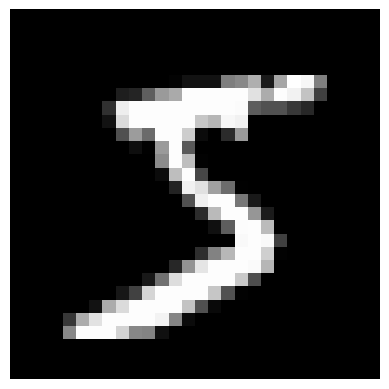

In [ ]:
# 顯示第1張圖片圖像
import matplotlib.pyplot as plt

# 第一筆資料
X = train_ds.data[0]

# 繪製點陣圖，cmap='gray':灰階
plt.imshow(X.reshape(28,28), cmap='gray')

# 隱藏刻度
plt.axis('off')

# 顯示圖形
plt.show()

## 步驟3：特徵工程，此步驟無需進行

In [ ]:
# train_ds.data = train_ds.data / 255.0
# test_ds.data = test_ds.data / 255.0

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [ ]:
# 建立模型
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 10),
    # 因使用nn.CrossEntropyLoss()時，內含softmax，故不需要將輸出經過softmax層，否則計算的損失會有誤
    # torch.nn.Softmax(dim=1)
).to(device)

## 步驟6：結合訓練資料及模型，進行模型訓練

‧ 第1行設定執行週期。

‧ 第2行設定學習率。

‧ 第5行設定 DataLoader,可一次取一批資料訓練,節省記憶體。

‧ 第8~9行設定優化器(Optimizer) : PyTorch 提供多種優化器,各有優點。

‧ 第 11行設定損失函數為交叉熵(CrossEntropyLoss),PyTorch 提供多種損失函數。

‧ 第 13行設定模型進入訓練階段,各神經層均會被執行,有別於評估階段。

‧ 第 14~32 行進行模型訓練,並顯示訓練過程與損失值,損失值多少不重要,
需觀察損失值是否隨著訓練逐漸收斂 ( 顯著減少)。

In [ ]:
epochs = 5
lr=0.1

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=600)

# 設定優化器(optimizer)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

model.train()
loss_list = []
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # if batch_idx == 0 and epoch == 1: print(data.shape)

        optimizer.zero_grad()
        output = model(data)
        # if batch_idx == 0 and epoch == 1: print(output.shape, target.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loss_list.append(loss.item())
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [    0 / 60000] (0 %)  Loss: 2.321291
Epoch 1: [ 6000 / 60000] (10 %)  Loss: 2.026389
Epoch 1: [12000 / 60000] (20 %)  Loss: 1.790763
Epoch 1: [18000 / 60000] (30 %)  Loss: 1.565405
Epoch 1: [24000 / 60000] (40 %)  Loss: 1.340660
Epoch 1: [30000 / 60000] (50 %)  Loss: 1.232226
Epoch 1: [36000 / 60000] (60 %)  Loss: 0.990201
Epoch 1: [42000 / 60000] (70 %)  Loss: 0.974444
Epoch 1: [48000 / 60000] (80 %)  Loss: 0.713364
Epoch 1: [54000 / 60000] (90 %)  Loss: 0.729845
Epoch 2: [    0 / 60000] (0 %)  Loss: 0.689033
Epoch 2: [ 6000 / 60000] (10 %)  Loss: 0.544343
Epoch 2: [12000 / 60000] (20 %)  Loss: 0.646912
Epoch 2: [18000 / 60000] (30 %)  Loss: 0.553244
Epoch 2: [24000 / 60000] (40 %)  Loss: 0.572928
Epoch 2: [30000 / 60000] (50 %)  Loss: 0.625178
Epoch 2: [36000 / 60000] (60 %)  Loss: 0.515424
Epoch 2: [42000 / 60000] (70 %)  Loss: 0.621332
Epoch 2: [48000 / 60000] (80 %)  Loss: 0.412318
Epoch 2: [54000 / 60000] (90 %)  Loss: 0.464400
Epoch 3: [    0 / 60000] (0 %)  Loss: 0.46

## 對訓練過程的損失繪圖

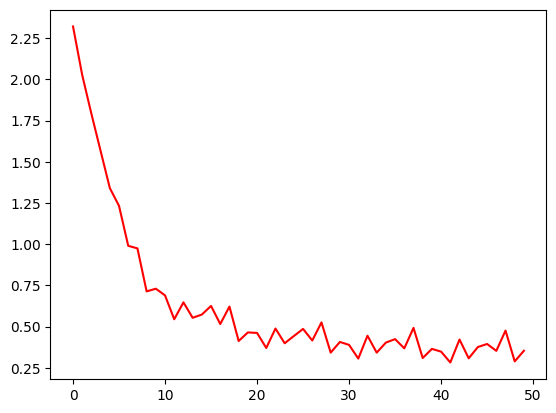

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步驟7：評分(Score Model)
‧ 第4行設定模型進入評估階段,Dropout 神經層不會被執行,因它是抑制過練階段,這一行非常重要,否則預測會失準。

‧ 第7~19 行預測所有測試資料,記得要包在 with torch.no_grad() 內,宣告內其的程式碼不作梯度下降,否則程式會出現錯誤。

‧ 第13行是計算損失並累加。

‧ 第 16行是預測並找最高機率的類別索引值 ,參數 keepdim=True 表示不修改output 變數的維度。

‧ 第 19 行是計算準確筆數並累加。


In [ ]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False, batch_size=test_ds.targets.shape[0])

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)

      # sum up batch loss
      test_loss += criterion(output, target).item()

      # 預測
      pred = output.argmax(dim=1, keepdim=True)

      # 正確筆數
      correct += pred.eq(target.view_as(pred)).sum().item()

# 平均損失
# test_loss /= len(test_loader.dataset)
# 顯示測試結果
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' +
      f' ({percentage:.0f}%)\n')

平均損失: 0.3348, 準確率: 9055/10000 (91%)



## 使用 torchmetrics

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.6 MB/s eta 0:00:00


In [ ]:
import torchmetrics

torchmetrics.functional.accuracy(pred.reshape(-1), test_ds.targets.to(device), task="multiclass", num_classes=10)

tensor(0.9055)

## 實際比對測試資料的前20筆

In [ ]:
# 實際預測 20 筆資料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比對
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4


In [ ]:
# 顯示第 9 筆的機率
import numpy as np

i=8
data = test_ds[i][0]
data = data.reshape(1, *data.shape).to(device)
#print(data.shape)
predictions = torch.softmax(model(data), dim=1)
print(f'0~9預測機率: {np.around(predictions.cpu().detach().numpy(), 2)}')
print(f'0~9預測機率: {np.argmax(predictions.cpu().detach().numpy(), axis=-1)}')

0~9預測機率: [[0.01 0.   0.06 0.   0.03 0.01 0.88 0.   0.01 0.  ]]
0~9預測機率: [6]


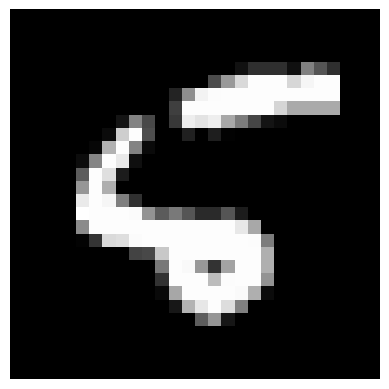

In [ ]:
# 顯示第 9 筆圖像
X2 = test_ds[i][0]
plt.imshow(X2.reshape(28,28), cmap='gray')
plt.axis('off')
plt.show()

## 步驟8：評估，暫不進行

## 步驟9：模型佈署
將最佳模型存檔,再開發使用者介面或提供 APl,連同模型檔一併佈署到上線環境 (Production Environment)。

In [ ]:
# 模型存檔
torch.save(model, 'model.pt')

# 模型載入
model = torch.load('model.pt')

In [ ]:
# 權重存檔
torch.save(model.state_dict(), 'model.pth')

# 權重載入
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [ ]:
# 顯示每一層的 state_dict 維度
print("每一層的 state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

每一層的 state_dict:
1.weight 	 torch.Size([256, 784])
1.bias 	 torch.Size([256])
3.weight 	 torch.Size([10, 256])
3.bias 	 torch.Size([10])


## 步驟10：新資料預測

In [ ]:
# 使用小畫家，繪製 0~9，實際測試看看
from skimage import io
from skimage.transform import resize
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
# 讀取影像並轉為單色
for i in range(10):
    uploaded_file = f'/content/drive/MyDrive/python_coding/MachineLearning/Neural_Network/myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 縮為 (28, 28) 大小的影像
    image_resized = resize(image1, (28, 28), anti_aliasing=True)
    X1 = image_resized.reshape(1,28, 28)

    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = torch.FloatTensor(1.0-X1).to(device)

    # 預測
    predictions = torch.softmax(model(X1), dim=1)
    # print(np.around(predictions.cpu().detach().numpy(), 2))
    print(f'actual/prediction: {i} {np.argmax(predictions.detach().cpu().numpy())}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 7
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 1
actual/prediction: 8 8
actual/prediction: 9 8


## 其他：顯示模型彙總資訊(summary)、繪製圖形顯示模型結構

In [ ]:
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
# 顯示模型的彙總資訊
for name, module in model.named_children():
    print(f'{name}: {module}')

0: Flatten(start_dim=1, end_dim=-1)
1: Linear(in_features=784, out_features=256, bias=True)
2: Dropout(p=0.2, inplace=False)
3: Linear(in_features=256, out_features=10, bias=True)


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, (60000, 28, 28)) # input dimension size

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [60000, 10]               --
├─Flatten: 1-1                           [60000, 784]              --
├─Linear: 1-2                            [60000, 256]              200,960
├─Dropout: 1-3                           [60000, 256]              --
├─Linear: 1-4                            [60000, 10]               2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
Total mult-adds (G): 12.21
Input size (MB): 188.16
Forward/backward pass size (MB): 127.68
Params size (MB): 0.81
Estimated Total Size (MB): 316.65

## PyTorch 無法繪製模型